In [1]:
#Import relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
from scipy import stats
import seaborn as sns

%matplotlib inline 

pd.set_option('display.max_columns', None)

In [2]:
#Initiating SQL connection
conn = sqlite3.connect('data/im.db')
cursor = conn.cursor()

In [3]:
#reading the rt.movie.info data
movie_info_df = pd.read_csv("data/rt.movie_info.tsv.gz", sep="\t", encoding='windows-1252')
movie_info_df.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


In [4]:
# need to change box_office dtype from object to int64
movie_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


In [5]:
#drop na values in box office and rating columns
movie_info_df.dropna(subset=['box_office', 'rating'], inplace=True)

In [6]:
#removing commas and making the value to int64
movie_info_df['box_office_clean'] = movie_info_df['box_office'].str.replace(",", "").astype(np.int64)

In [7]:
#count of each rating type
movie_info_df['rating'].value_counts()

R        142
PG-13    117
PG        52
NR        19
G          9
NC17       1
Name: rating, dtype: int64

In [8]:
#box office total per rating
movie_info_df.groupby(by = 'rating').sum()['box_office_clean']

rating
G         274031600
NC17        1260219
NR         47238725
PG       2653744950
PG-13    6612858122
R        3298910048
Name: box_office_clean, dtype: int64

In [9]:
#making rating column binary - R or non-R
movie_info_df['rating'].replace("G","Non-R", inplace=True)
movie_info_df['rating'].replace("NC17", "R", inplace=True)
movie_info_df['rating'].replace("NR", "Non-R", inplace=True)
movie_info_df['rating'].replace("PG", "Non-R", inplace=True)
movie_info_df['rating'].replace("PG-13", "Non-R", inplace=True)

In [10]:
#confirming above code worked
movie_info_df['rating'].value_counts()

Non-R    197
R        143
Name: rating, dtype: int64

In [11]:
#box office total per rating
movie_info_df.groupby(by = 'rating').sum()['box_office_clean']

rating
Non-R    9587873397
R        3300170267
Name: box_office_clean, dtype: int64

In [12]:
#Getting box office values for R and non-R categories
R = movie_info_df[movie_info_df['rating'] == 'R']['box_office_clean'].values
non_R = movie_info_df[movie_info_df['rating'] == 'Non-R']['box_office_clean'].values

In [13]:
#Creating samples for each category

#Q: Should we do sample. Technically, sample size don't need to be equal

sample_R = np.random.choice(R, size=100, replace=False)
sample_non_R = np.random.choice(non_R, size=100, replace=False)

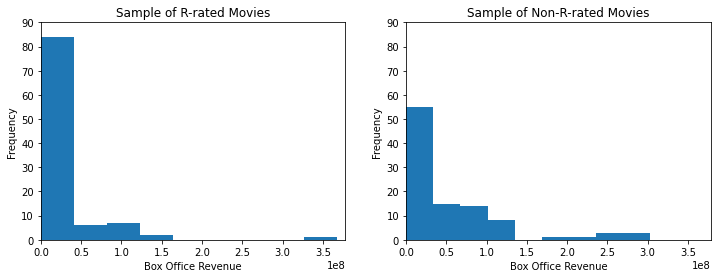

In [14]:
#Visuals - bar charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

bin_size = 9

ax1.set_title('Sample of R-rated Movies')
ax1.set_xlabel('Box Office Revenue')
ax1.set_ylabel('Frequency')
ax1.hist(sample_R, bins = bin_size)

ax2.set_title('Sample of Non-R-rated Movies')
ax2.set_xlabel('Box Office Revenue')
ax2.set_ylabel('Frequency')
ax2.hist(sample_non_R, bins = bin_size)

max_x = max(max(sample_R), max(sample_non_R)) + 10000000
max_y = 90

ax1.set_xlim(0, max_x)
ax1.set_ylim(0, max_y)
ax2.set_xlim(0, max_x)
ax2.set_ylim(0, max_y)

plt.show();

### Hypothesis
- **Null Hypothesis**: R-rated movies bring in greater or equal box office revenue than Non-R-rated movies
- **Alternate Hypothesis**: R-rated movies bring in less box office revenue than Non-R-rated movies

In [15]:
#Two sample t-test
pvalue = stats.ttest_ind(sample_R, sample_non_R, equal_var = False).pvalue / 2
pvalue

0.0005945028303165683

### First Business Recommendation (make sure to change p-value as you re-run the model)

We've set our alpha to be 0.05. Based on the Alpha and p-value of 3.68e-05, we reject the null hypothesis and conclude that R-rated movies bring in less box office revenue than Non-R movies. Therefore, it will be beneficial for the Company to pursue non-R movies. 

### Limitations to the Analysis
- Do NOT filter for movie release date. Considering all data points in the data set due to limited data
- Do NOT adjust for inflation for the box office revenue
- Do NOT account for the budget of each title

In [16]:
# R Action movies vs Non-R Action movies
R_Action = movie_info_df[(movie_info_df['genre'].str.contains('Action')) 
                         & (movie_info_df['rating'] == 'R')]['box_office_clean'].values
Non_R_Action = movie_info_df[(movie_info_df['genre'].str.contains('Action')) 
                             & (movie_info_df['rating'] == 'Non-R')]['box_office_clean'].values

In [17]:
R_Action_sample = np.random.choice(R_Action, size=20, replace=False)
Non_R_Action_sample = np.random.choice(Non_R_Action, size=20, replace=False)

len(Non_R_Action_sample)

20

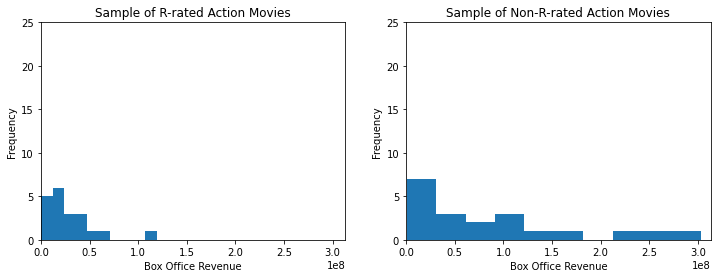

In [18]:
# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

bin_size = 10

ax1.set_title('Sample of R-rated Action Movies')
ax1.set_xlabel('Box Office Revenue')
ax1.set_ylabel('Frequency')
ax1.hist(R_Action_sample, bins = bin_size)

ax2.set_title('Sample of Non-R-rated Action Movies')
ax2.set_xlabel('Box Office Revenue')
ax2.set_ylabel('Frequency')
ax2.hist(Non_R_Action_sample, bins = bin_size)

max_x = max(max(R_Action_sample), max(Non_R_Action_sample)) + 10000000
max_y = 25

ax1.set_xlim(0, max_x)
ax1.set_ylim(0, max_y)
ax2.set_xlim(0, max_x)
ax2.set_ylim(0, max_y)

plt.show();

In [19]:
#Two sample t-test
pvalue = stats.ttest_ind(R_Action_sample, Non_R_Action_sample, equal_var = False).pvalue / 2
pvalue

0.004869347374942289